# 案例学习： 基于手动设计特征和SVM的手写数字分类
日期: 2018/08/27 | 作者: liubai01 | 语言: python3
## 1 前言
教程旨在体验经典CV方法识别手写数字，为机器学习入门学习的同学提供有趣的案例研究。
![title](img/flowchart_ai.png)
摘自于[Deep Learning book](http://www.deeplearningbook.org/)的AI方法历史演变图
作者BLOG链接：[传送门](https://blog.csdn.net/liubai01)

## 2 任务
设计一个简单的分类器，识别出0和8。数据库基于MNIST提取出0和8数据各500个。
### 2.1 前置要求
*   基础的python编程能力
*   大致了解SVM(support vector machine)支持向量机的相关内容

### 2.2 学习目标
*   理解手动设计特征的过程
*   掌握调用sklearn去完成分类器
*   了解经典CV方法手动设计特征的过程

## 3 加载数据
![title](img/workflow01.png)

In [1]:
# 加载需要的库
import pickle
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils.visualize_data import visualize_db, visualize_feat_1d, visualize_feat_2d, visualize_model, visualize_pred_result
from utils.connected_component import get_components
from matplotlib.colors import ListedColormap

In [2]:
# 加载数据
db_path = os.path.join(".", "data", "hand_designed_train.pkl")
with open(db_path, "rb") as f:
    X, y = pickle.load(f)

### 3.1 数据类型
数据X为numpy的array, 形状为\[数据个数x1x28x28\]。额外的1维度是用于代表，输入图像为灰度图，用于以后与RGB三通道图像做区分。

数据Y为标签。在这个问题里，只有两种标签：0和8

In [3]:
# 查看输入Tensor的形状
print(X.shape)
print(y.shape)

(1000, 1, 28, 28)
(1000,)


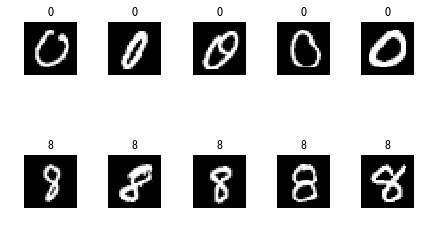

In [5]:
# 数据可视化
visualize_db(X, y)

## 4 特征工程（feature engineering）
传统机器学习的第一步，是将**原始数据（raw data）**转化成**特征向量（feature vector）**。例如：灰度图->(图像高度，图像宽度)。但是显然，所有数字的特征向量都是一样的。我们没法基于这样的向量做分类。通过人类的先验知识或者领域知识（domain knowledge），进行特征向量设计的做法，我们叫做**特征工程（feature engineering）**。在手写数字识别里面，我们可以采用例如平均像素强度，对称性等等，作为特征向量。
![title](img/workflow02.png)

### 4.1 特征样例1： 像素强度总和
我们有这样的直觉：8需要的笔画多，0需要的少。输入数据是一个矩阵，每一个元素的值代表这一个点的**像素强度（pixel intensity）**。我们不如把所有点的像素强度加起来，看看数据是不是可分。

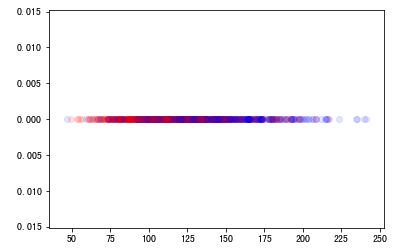

In [5]:
X_feat = []
sample_num = y.shape[0]
for i in range(sample_num):
    now_x = X[i][0]
    pixel_intensity_sum = np.sum(now_x)
    X_feat.append(pixel_intensity_sum)

X_feat = np.array(X_feat)
visualize_feat_1d(X_feat, y)

看上去效果一般，并不能十分明显的区分（红色的是8,蓝色的是0）。并且事实上，似乎0花费的平均像素强度更高。

### 4.2 特征样例2： 连通分量
8比0有什么地方不一样？8中间有两个圈，0中间只有一个圈。我们引用图论的说法，把连在一起的空白区域叫做一个**连通分量（connected component）**。我们希望借助这一特征能够区别数字。
![title](img/connected_component.png)

由于计算连通分量的过程比较复杂，过程比较无趣。这里给了一个简单的实现函数get_components。输入一个2d的图像矩阵，会输出两个参数。第一个就输出连通分量个数（第二个输出后面会有解释）

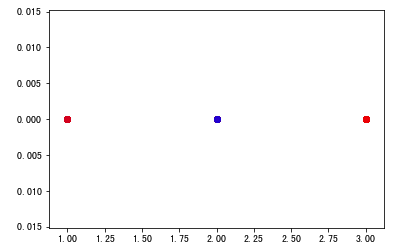

In [6]:
X_feat = []
sample_num = y.shape[0]
for i in range(sample_num):
    now_x = X[i][0]
    com_num, _ = get_components(now_x)
    X_feat.append(com_num)

X_feat = np.array(X_feat)
visualize_feat_1d(X_feat, y)

看上去效果很好！，这一特征我们能够采用！

### 4.3 特征样例3：第二大连通分量面积
基于上面那个特征，经过思考，我想到了连通分量面积最大的肯定是外围，第二大的是8或者0里面的区域。一般来说，0的第二大连通分量的面积应该较大。我们实验一下

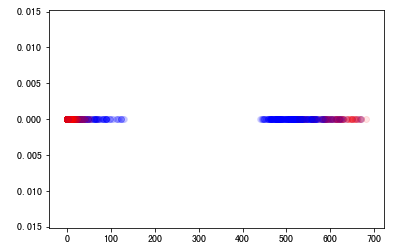

In [7]:
X_feat = []
sample_num = y.shape[0]
for i in range(sample_num):
    now_x = X[i][0]
    _, sec_com_area = get_components(now_x)
    X_feat.append(sec_com_area)

X_feat = np.array(X_feat)
visualize_feat_1d(X_feat, y)

我们发现，效果还是不不错的，虽然没有前面连通分量数量来的优秀，但是数据点也分离得很好。但是令人意外的是，0主要集中在中间，8分布在两边。

### 4.4 练习： 自己思考一个特征，并进行测试

In [8]:
X_feat = []
sample_num = y.shape[0]
for i in range(sample_num):
    now_x = X[i][0]
    # 开始：学生代码
    # X_feat.append(TODO)
    # 结束：学生代码

X_feat = np.array(X_feat)
# visualize_feat_1d(X_feat, y)

### 4.5 选取两个特征
作为样例的结束，我们采用两个特征：连通分量数量，第二大连通分量面积

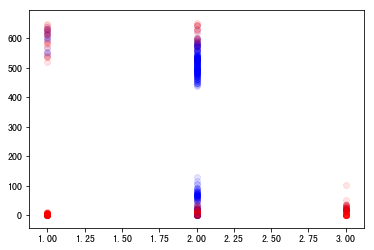

In [6]:
X_feat = []
sample_num = y.shape[0]
for i in range(sample_num):
    now_x = X[i][0]
    com_num, sec_com_area = get_components(now_x)
    # 在这里修改特征向量！
    X_feat.append([com_num, sec_com_area])

X_feat = np.array(X_feat)
visualize_feat_2d(X_feat, y)

## 5 训练一个SVM分类器
![title](img/workflow03.png)

In [15]:
# 从sckit-learn包中导入svm模型
from sklearn import svm
# 方便调节fiugre大小
import pylab

In [9]:
# 生成并训练分类器
model = svm.SVC(C=2)
X_feat_reframe = []
for x in X_feat:
    X_feat_reframe.append(x)
model.fit(X_feat_reframe, y)  

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## 6 测试模型
![title](img/workflow04.png)

In [11]:
# 测试并查看训练集的正确率（In-sample accuracy）
sample_num = y.shape[0]
acc = np.sum(model.predict(X_feat_reframe) == y) / sample_num
print("Accuracy={}".format(acc))

Accuracy=0.944


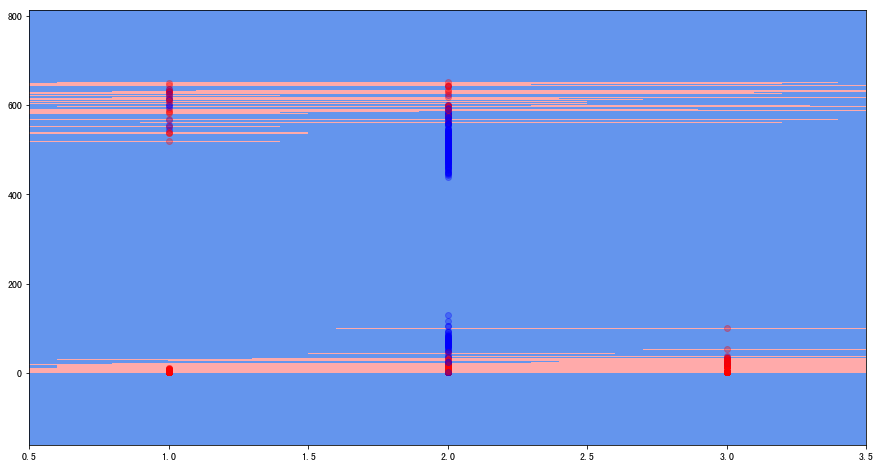

In [12]:
# 可视化分类器的决策边界

pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小
visualize_model(model, X_feat, y)

Accuracy=0.91


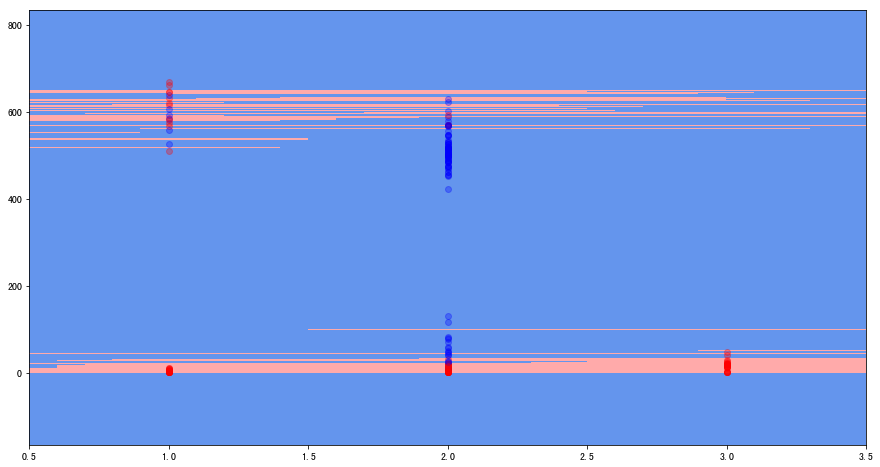

In [16]:
# 导入测试集
# 加载测试数据
db_path = os.path.join(".", "data", "hand_designed_test.pkl")
with open(db_path, "rb") as f:
    X_test, y_test = pickle.load(f)
# 转换为特征向量（feature vector）
X_feat_test = []
sample_num_test = y_test.shape[0]
for i in range(sample_num_test):
    now_x = X_test[i][0]
    com_num, sec_com_area = get_components(now_x)
    X_feat_test.append([com_num, sec_com_area])
# 放入分类器预测， 输出测试集正确率（Out-of-sample accuracy）
acc = np.sum(model.predict(X_feat_test) == y_test) / sample_num_test
print("Accuracy={}".format(acc))
# 可视化决策边界
X_feat_test = np.array(X_feat_test)
visualize_model(model, X_feat_test, y_test)

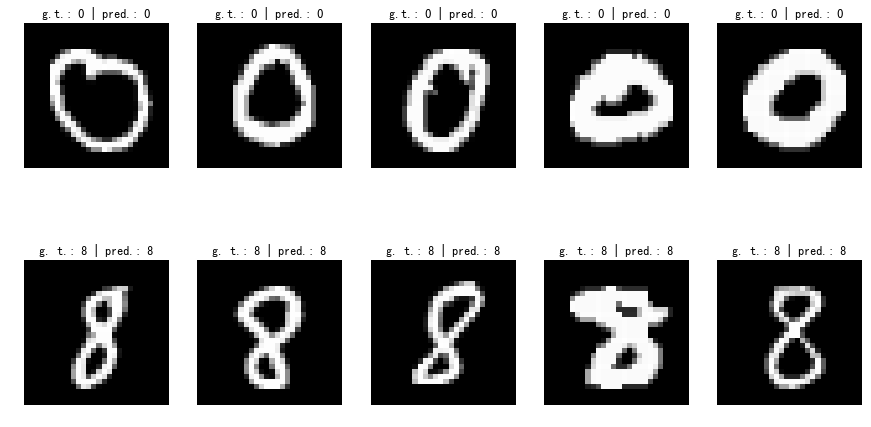

In [17]:
# 结果可视化 
visualize_pred_result(model, X_test, X_feat_test, y_test)

## Acknowledgement
1. 数据来自于 [Mnist Database](http://yann.lecun.com/exdb/mnist/)
2. 介绍部分图片来自于 Deep Learning Book